In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
import pandas as pd

url = "https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Complete_TAVG_daily.txt"

'''
read the data from the url link
ignore the comments starting with '%'
ignore the header in the comments and assign manually
'''
df = pd.read_csv(url, sep=r"\s+", comment="%", header=None)

# assign column headers
column_names = ["Date Number", "Year", "Month", "Day", "Day of Year", "Anomaly"]
df.columns = column_names

df.to_csv("data/raw.csv", index=False)

In [4]:
df = df.drop(columns=['Date Number'])

In [5]:
BASELINE_TEMP = 8.59  # Jan 1951–Dec 1980 land-average temperature in celsius

df['Temperature'] = df['Anomaly'] + BASELINE_TEMP

In [6]:
month_dict = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

df['Month_Name'] = df['Month'].map(month_dict)

## ML 

Here we convert daily climate data into yearly averages by creating a proper datetime index, resampling the anomaly values to annual means, and preparing the data for modeling by extracting the numerical year and separating it into feature (X) and target (y) arrays. Yearly averages smooth out short-term noise and make long-term climate trends easier to model, and using the year as the feature allows the machine-learning models to learn how temperature anomalies evolve over time.

In [7]:
# -----------------------------------------------------------
# 1. Convert daily data → yearly averages
# -----------------------------------------------------------

# Combine Year–Month–Day into a proper datetime column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Use Date as index so resampling works correctly
df.set_index('Date', inplace=True)

# Resample to yearly means (YE = year-end)
yearly = df['Anomaly'].resample('YE').mean().reset_index()

# Extract year number from datetime column
yearly['Year'] = yearly['Date'].dt.year

# Feature matrix X (year), target vector y (anomaly)
X = yearly[['Year']].values
y = yearly['Anomaly'].values

We split the data into a training set (years up to 2012) and a test set (years after 2012) by creating boolean masks based on the chosen split year. It then uses those masks to separate the feature matrix and target values into training and testing subsets. By training on earlier years and testing on later years, we evaluate how well the model predicts future climate patterns rather than just fitting past data. A good model should perform well on the test set, meaning it can generalize to years it has never seen before.

In [8]:
# -----------------------------------------------------------
# 2. Train–Test Split (train: up to 2012, test: after 2012)
# -----------------------------------------------------------

split_year = 2012  # last 10 years are used for testing

train_mask = yearly['Year'] <= split_year
test_mask  = yearly['Year'] > split_year

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask], y[test_mask]

Three different machine-learning models are defined which are Linear Regression, Random Forest, and a Support Vector Regressor (SVR) with scaling—so we can compare how well each one predicts yearly temperature anomalies. Each model captures patterns differently, ranging from simple linear trends to more flexible non-linear relationships.

In [9]:
# -----------------------------------------------------------
# 3. Define Models
# -----------------------------------------------------------

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "SVR": Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01))
    ])
}

WE train each defined model on the training data, predicts anomalies for the test years, and calculates key evaluation metrics (RMSE, MAE, R²) to measure prediction accuracy. The results are stored in a table for easy comparison of model performance.

In [10]:
# -----------------------------------------------------------
# 4. TRAIN, PREDICT & EVALUATE (Output results as table)
# -----------------------------------------------------------

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)                     # Train
    y_pred = model.predict(X_test)                  # Predict
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
    mae  = mean_absolute_error(y_test, y_pred)      
    r2   = r2_score(y_test, y_pred)                 # Evaluate

    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

# Convert results dictionary → nice DataFrame table
results_table = pd.DataFrame(results).T
print("\nModel Performance on Test Set:\n")
print(results_table)


Model Performance on Test Set:

                       RMSE       MAE         R2
Linear Regression  0.539126  0.521939 -11.652955
Random Forest      0.350576  0.316120  -4.350267
SVR                0.145067  0.120141   0.083892


Lower RMSE and MAE values indicate more accurate predictions, while a higher (positive) R² shows the model explains more variance in the data. From the table, SVR has the lowest errors and a positive R², making it the best model to use for forecasting.

In [11]:
# -----------------------------------------------------------
# 5. Select Best Model (based on RMSE)
# -----------------------------------------------------------

best_model_name = results_table["RMSE"].idxmin()
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")


Best model: SVR


We use the selected best model (SVR) to predict the temperature anomaly for the year 2030 and then adds it to the baseline temperature to estimate the actual land-average temperature.

In [12]:
# -----------------------------------------------------------
# 6. Forecast Temperature Anomaly for 2030
# -----------------------------------------------------------

year_2030 = np.array([[2030]])
forecast_2030_anomaly = best_model.predict(year_2030)[0]

forecast_2030_temp = BASELINE_TEMP + forecast_2030_anomaly

print(f"\nPredicted anomaly for 2030: {forecast_2030_anomaly:.4f} °C")
print(f"Predicted land-average temperature for 2030: {forecast_2030_temp:.4f} °C")


Predicted anomaly for 2030: 1.9696 °C
Predicted land-average temperature for 2030: 10.5596 °C


The predicted anomaly of **≈1.97 °C** indicates that 2030 is expected to be nearly 2 °C warmer than the baseline period. Adding this to the baseline gives a land-average temperature of **≈10.56 °C**, showing a continuation of the observed warming trend.


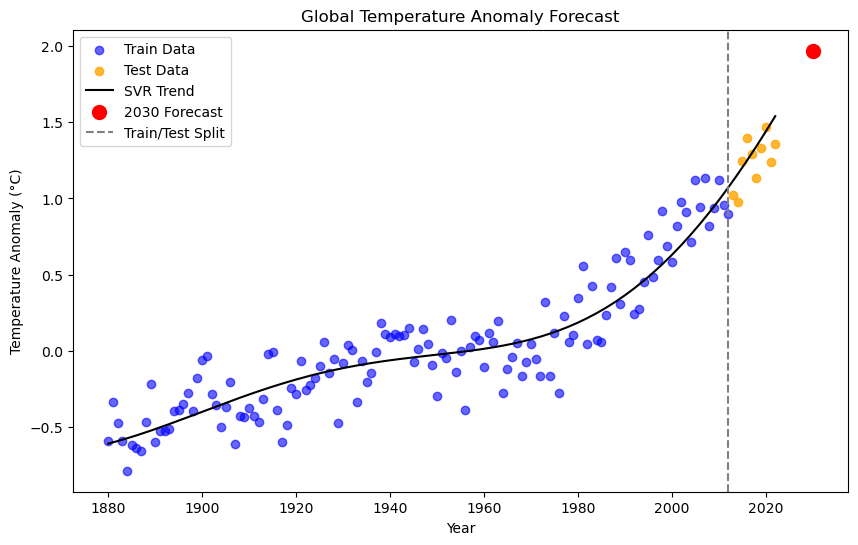

In [13]:
# -----------------------------------------------------------
# 7. PLOT RESULTS
# -----------------------------------------------------------

plt.figure(figsize=(10,6))

# Plot TRAIN data (blue)
plt.scatter(
    yearly['Year'][train_mask],
    yearly['Anomaly'][train_mask],
    alpha=0.6,
    color='blue',
    label="Train Data"
)

# Plot TEST data (orange/red)
plt.scatter(
    yearly['Year'][test_mask],
    yearly['Anomaly'][test_mask],
    alpha=0.8,
    color='orange',
    label="Test Data"
)

# Model trend line
plt.plot(yearly['Year'], best_model.predict(X), color='black', label=f"{best_model_name} Trend")

# 2030 Forecast point
plt.scatter(2030, forecast_2030_anomaly, color='red', s=100, label="2030 Forecast")

# Train-test split line
plt.axvline(split_year, color='gray', linestyle='--', label="Train/Test Split")

plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.title("Global Temperature Anomaly Forecast")
plt.legend()
plt.show()

The plot shows the historical anomalies, with training data in blue and test data in orange, allowing us to visually compare the model’s predictions against unseen years. The black trend line from the SVR model captures the warming pattern, while the red point highlights the 2030 forecast, illustrating the expected continuation of the temperature rise.

The trend line closely follows historical data, test points are reasonably well-predicted, and the red forecast indicates that temperature anomalies are expected to continue rising, consistent with recent warming trends.